<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Mon Nov 27 14:32:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:D8:00.0 Off |                    0 |
| N/A   28C    P0    24W / 250W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.1+cu118


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
from pathlib import Path
from zipfile import ZipFile
import requests
import os

# url to data
url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

def download_data(url, remove_source=True):

    # data and image paths
    data_path = Path("data")
    image_path = data_path / "images"

    # create image directory
    image_path.mkdir(parents=True, exist_ok=True)
    
    # download the zip file to data path
    with open(data_path / "image.zip", "wb") as f:
        request = requests.get(url)
        f.write(request.content)
    
    # extract zip file to image directory
    with ZipFile(data_path / "image.zip", "r") as zipref:
        zipref.extractall(image_path)

    if remove_source:
        os.remove(data_path / "image.zip")

    return image_path

image_path = download_data(url=url)
image_path

PosixPath('data/images')

In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(dir_path=image_path)

There are 2 directories and 0 images in 'data/images'.
There are 3 directories and 0 images in 'data/images/test'.
There are 0 directories and 25 images in 'data/images/test/pizza'.
There are 0 directories and 19 images in 'data/images/test/steak'.
There are 0 directories and 31 images in 'data/images/test/sushi'.
There are 3 directories and 0 images in 'data/images/train'.
There are 0 directories and 78 images in 'data/images/train/pizza'.
There are 0 directories and 75 images in 'data/images/train/steak'.
There are 0 directories and 72 images in 'data/images/train/sushi'.


In [5]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"
train_path, test_path

(PosixPath('data/images/train'), PosixPath('data/images/test'))

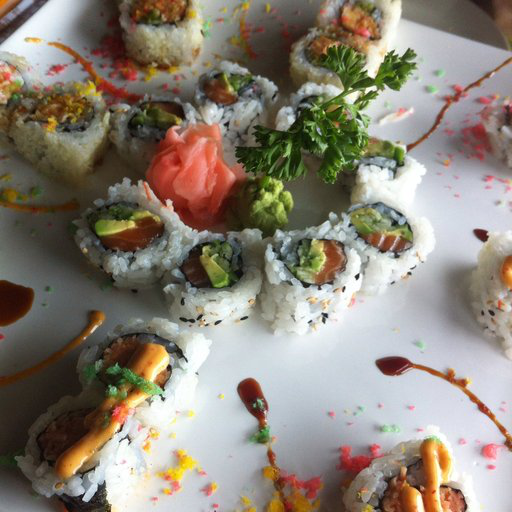

In [6]:
# Visualize an image
from PIL import Image
import random

random_path = random.choice(list(image_path.glob("*/*/*.jpg")))

img = Image.open(random_path)
img

torch.Size([3, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

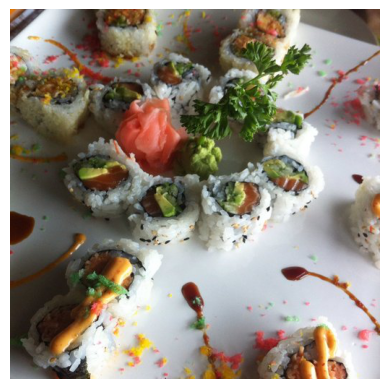

In [7]:
# Do the image visualization with matplotlib
from torchvision import transforms
import matplotlib.pyplot as plt

ToTensor = transforms.ToTensor()
img_tensor = ToTensor(img)
print(img_tensor.shape)
plt.imshow(img_tensor.permute(1,2,0))
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms

In [9]:
# Write transform for turning images into tensors
transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

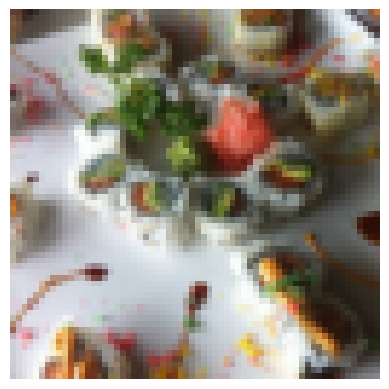

In [10]:
# Write a function to plot transformed images
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

def visualize(img: Image.Image,
             transform: torchvision.transforms):

    img_transformed = transform(img)
    plt.imshow(img_transformed.permute(1,2,0))
    plt.axis(False)

visualize(img=img, transform=transform)

### Load image data using `ImageFolder`

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_data = ImageFolder(
    root=train_path,
    transform=transform,
    target_transform=None
)

test_data = ImageFolder(
    root=test_path,
    transform=transform,
    target_transform=None
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/images/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                RandomHorizontalFlip(p=0.5)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/images/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                RandomHorizontalFlip(p=0.5)
            ))

In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCHSIZE = 32
NUMWORKERS = 1

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCHSIZE,
    shuffle=True,
    num_workers=NUMWORKERS
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCHSIZE,
    shuffle=False,
    num_workers=NUMWORKERS
)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7f78cba8e190>,
 <torch.utils.data.dataloader.DataLoader at 0x7f78cbb87a90>)

In [16]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [17]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, in_channels: int, out_channels:int, hidden_units:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=out_channels)
        )

    def forward(self, x:torch.Tensor):
        return self.classifier(self.block2(self.block1(x)))

model = TinyVGG(in_channels=3, out_channels=len(train_data.classes), hidden_units=10).to(device)
model

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
    model.train()

  # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
    for batch, (X, y) in enumerate(dataloader): 
    # Send data to target device
        X, y = X.to(device), y.to(device)

    # 1. Forward pass
        y_logit = model(X)
        
    # 2. Calculate and accumulate loss
        loss = loss_fn(y_logit, y)
        train_loss += loss.item()
        
    # 3. Optimizer zero grad 
        optimizer.zero_grad()
    
    # 4. Loss backward 
        loss.backward()

    # 5. Optimizer step
        optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
        y_preds = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)
        train_acc += torch.sum(y_preds == y).item() / len(y_preds)

  # Adjust metrics to get average loss and average accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
    model.eval()

  # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

  # Turn on inference context manager
    with torch.inference_mode():
    # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):    
      # Send data to target device
            X, y = X.to(device), y.to(device)

      # 1. Forward pass
            y_logits = model(X)

      # 2. Calculuate and accumulate loss
            test_loss += loss_fn(y_logits, y).item()

      # Calculate and accumulate accuracy
            y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            test_acc += torch.sum(y_preds == y).item() / len(y_preds)
            
  # Adjust metrics to get average loss and accuracy per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc

In [20]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [21]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), #TODO, 
                             lr=0.001)

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1005 | train_acc: 0.2500 | test_loss: 1.0980 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0967 | train_acc: 0.4258 | test_loss: 1.1002 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0953 | train_acc: 0.4258 | test_loss: 1.1030 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1005 | train_acc: 0.3047 | test_loss: 1.1096 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1227 | test_acc: 0.2604


In [22]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), #TODO, 
                             lr=0.001)


results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0934 | train_acc: 0.4258 | test_loss: 1.1058 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0798 | train_acc: 0.4258 | test_loss: 1.1152 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0604 | train_acc: 0.4258 | test_loss: 1.1440 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0977 | train_acc: 0.3047 | test_loss: 1.1131 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0577 | train_acc: 0.5703 | test_loss: 1.0988 | test_acc: 0.3722
Epoch: 6 | train_loss: 1.0581 | train_acc: 0.4297 | test_loss: 1.1698 | test_acc: 0.3125
Epoch: 7 | train_loss: 0.9755 | train_acc: 0.5781 | test_loss: 1.0783 | test_acc: 0.4233
Epoch: 8 | train_loss: 0.9339 | train_acc: 0.5938 | test_loss: 1.1459 | test_acc: 0.3731
Epoch: 9 | train_loss: 1.0041 | train_acc: 0.4570 | test_loss: 1.0141 | test_acc: 0.4441
Epoch: 10 | train_loss: 0.9466 | train_acc: 0.4492 | test_loss: 0.9314 | test_acc: 0.5436
Epoch: 11 | train_loss: 0.8596 | train_acc: 0.5938 | test_loss: 1.0635 | test_acc: 0.3419
Epoch: 12 | train_l

In [23]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), #TODO, 
                             lr=0.001)


results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7986 | train_acc: 0.5586 | test_loss: 1.1725 | test_acc: 0.4129
Epoch: 2 | train_loss: 0.7966 | train_acc: 0.6680 | test_loss: 1.0604 | test_acc: 0.4034
Epoch: 3 | train_loss: 0.7010 | train_acc: 0.6836 | test_loss: 0.9586 | test_acc: 0.4848
Epoch: 4 | train_loss: 0.6620 | train_acc: 0.7305 | test_loss: 1.0219 | test_acc: 0.4650
Epoch: 5 | train_loss: 0.6376 | train_acc: 0.7188 | test_loss: 1.0411 | test_acc: 0.4754
Epoch: 6 | train_loss: 0.7825 | train_acc: 0.5898 | test_loss: 0.9956 | test_acc: 0.5360
Epoch: 7 | train_loss: 0.6650 | train_acc: 0.7031 | test_loss: 1.2357 | test_acc: 0.4138
Epoch: 8 | train_loss: 0.6979 | train_acc: 0.6875 | test_loss: 1.0293 | test_acc: 0.4347
Epoch: 9 | train_loss: 0.7826 | train_acc: 0.5820 | test_loss: 1.0212 | test_acc: 0.4233
Epoch: 10 | train_loss: 0.6660 | train_acc: 0.7227 | test_loss: 0.9511 | test_acc: 0.5350
Epoch: 11 | train_loss: 0.6309 | train_acc: 0.7422 | test_loss: 1.1102 | test_acc: 0.4138
Epoch: 12 | train_l

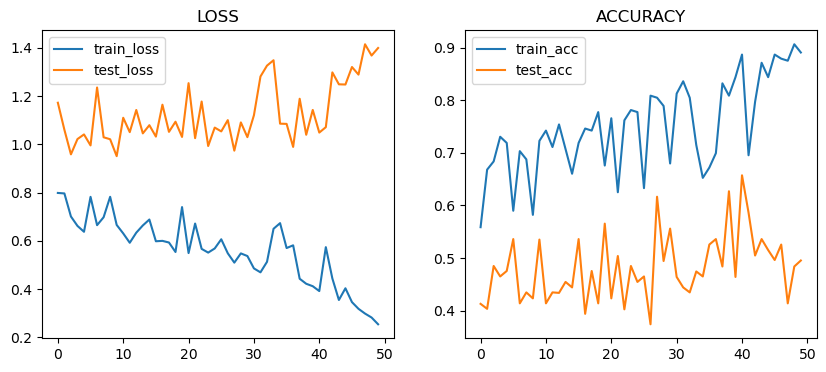

In [24]:
from typing import Dict
import matplotlib.pyplot as plt

def plot_results(results: Dict):
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))

    ax[0].plot(results["train_loss"], label="train_loss")
    ax[0].plot(results["test_loss"], label="test_loss")
    ax[0].set_title("LOSS")
    ax[0].legend()

    ax[1].plot(results["train_acc"], label="train_acc")
    ax[1].plot(results["test_acc"], label="test_acc")
    ax[1].set_title("ACCURACY")
    ax[1].legend()

plot_results(results=results)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [25]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_20 = TinyVGG(in_channels=3, out_channels=len(train_data.classes), hidden_units=20).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_20.parameters(), lr=1e-3)

results = train(
    model = model_20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn = loss_fn,
    optimizer=optimizer,
    epochs=20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1029 | train_acc: 0.4375 | test_loss: 1.1054 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1260 | train_acc: 0.3047 | test_loss: 1.0993 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0932 | train_acc: 0.3633 | test_loss: 1.0958 | test_acc: 0.2699
Epoch: 4 | train_loss: 1.0987 | train_acc: 0.3320 | test_loss: 1.0715 | test_acc: 0.5426
Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3867 | test_loss: 1.0666 | test_acc: 0.2812
Epoch: 6 | train_loss: 1.0562 | train_acc: 0.4336 | test_loss: 1.0878 | test_acc: 0.3125
Epoch: 7 | train_loss: 0.9582 | train_acc: 0.5781 | test_loss: 1.1134 | test_acc: 0.3125
Epoch: 8 | train_loss: 0.8998 | train_acc: 0.5742 | test_loss: 1.0649 | test_acc: 0.3400
Epoch: 9 | train_loss: 0.9551 | train_acc: 0.4570 | test_loss: 0.9732 | test_acc: 0.5057
Epoch: 10 | train_loss: 0.8497 | train_acc: 0.6406 | test_loss: 1.0993 | test_acc: 0.3409
Epoch: 11 | train_loss: 0.8634 | train_acc: 0.6094 | test_loss: 1.0488 | test_acc: 0.3816
Epoch: 12 | train_l

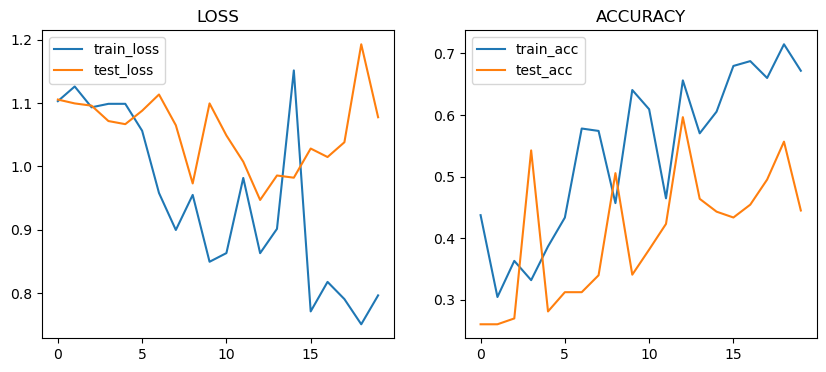

In [26]:
plot_results(results=results)

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [27]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [28]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.


Excellent, we now have double the training and testing images... 

In [29]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [30]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20 = ImageFolder(
    root=train_data_20_percent_path,
    transform=simple_transform
)

test_data_20 = ImageFolder(
    root=test_data_20_percent_path,
    transform=simple_transform
)

# Create dataloaders
train_dataloader_20 = DataLoader(
    train_data_20,
    batch_size=BATCHSIZE,
    shuffle=True
)

test_dataloader_20 = DataLoader(
    test_data_20,
    batch_size=BATCHSIZE,
    shuffle=True
)

In [31]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

results = train(
    model=model,
    train_dataloader=train_dataloader_20,
    test_dataloader=test_dataloader_20,
    loss_fn = loss_fn,
    optimizer=optimizer,
    epochs=50
)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8766 | train_acc: 0.6542 | test_loss: 0.8919 | test_acc: 0.6216
Epoch: 2 | train_loss: 0.6880 | train_acc: 0.7229 | test_loss: 0.8309 | test_acc: 0.6494
Epoch: 3 | train_loss: 0.6316 | train_acc: 0.7646 | test_loss: 0.8276 | test_acc: 0.5966
Epoch: 4 | train_loss: 0.6150 | train_acc: 0.7604 | test_loss: 0.8171 | test_acc: 0.6392
Epoch: 5 | train_loss: 0.5768 | train_acc: 0.7896 | test_loss: 0.8486 | test_acc: 0.6460
Epoch: 6 | train_loss: 0.5892 | train_acc: 0.7375 | test_loss: 0.9577 | test_acc: 0.6023
Epoch: 7 | train_loss: 0.5754 | train_acc: 0.7750 | test_loss: 0.8245 | test_acc: 0.6449
Epoch: 8 | train_loss: 0.5455 | train_acc: 0.7583 | test_loss: 0.8460 | test_acc: 0.6273
Epoch: 9 | train_loss: 0.4838 | train_acc: 0.8333 | test_loss: 0.8753 | test_acc: 0.6335
Epoch: 10 | train_loss: 0.4241 | train_acc: 0.8500 | test_loss: 0.9603 | test_acc: 0.6057
Epoch: 11 | train_loss: 0.4776 | train_acc: 0.8271 | test_loss: 0.9475 | test_acc: 0.6148
Epoch: 12 | train_l

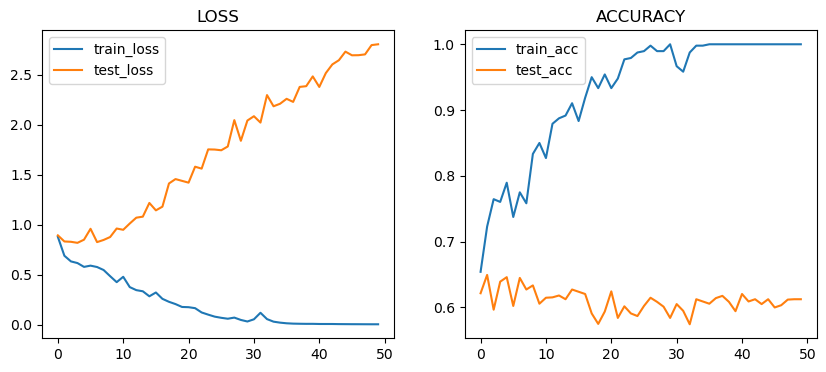

In [32]:
plot_results(results=results)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?